# Comparing qstack and Qiskit: Repeat-Until-Success with Error Correction

This example demonstrates how to implement a repeat-until-success pattern with error correction using both qstack and Qiskit.

We'll show how to:
1. Implement a basic repeat-until-success pattern
2. Add error correction using a 3-qubit repetition code
3. Extend to a nested 9-qubit repetition code

The comparison highlights different approaches to quantum program transformation and error correction in these frameworks.

Let's first look at the qstack implementation (already in the notebook), then implement the equivalent functionality in Qiskit.

# Compositional Compilation in qstack

This example demonstrates how qstack's compiler framework can transform quantum programs across multiple levels of abstraction. We'll start with a simple repeat-until-success program using the toy instruction set and transform it through several compilation steps to add error correction.

Key features demonstrated:

1. **Instruction set translation** - Converting from toy instructions to standard gates
2. **Error correction** - Adding repetition code for fault tolerance
3. **Callback transformation** - Automatically adapting classical control logic
4. **Resource allocation** - Handling qubit expansion from 1 to 9 qubits

We'll first look at the qstack implementation, then show an equivalent approach using Qiskit for comparison.


In [15]:
# Set up the environment
from qstack import Program, Kernel, ClassicInstruction
from qstack.instruction_sets.toy import Mix
from qstack.machine import create_callbacks

# Load program and create callbacks (using the repeat_until_zero function defined above)
original_program = Program.from_string("""
@instruction-set: toy
                                       
allocate q1:
  mix q1
measure 
?? repeat_until_zero
""")


def repeat_until_zero(context):
    m = context.consume()  # Get the measurement result
    context.collect(m)  # Push the result back to the context so it shows in the output
    
    if m == 1:
        # If we measured 1, create a new kernel to try again
        return Kernel.allocate("q1", 
                  instructions=[Mix("q1")],
                  callback=ClassicInstruction("repeat_until_zero"))
    else:
        # If we measured 0, we're done
        return None

original_callbacks = create_callbacks(repeat_until_zero)

print(original_program)

@instruction-set: toy

allocate q1:
  mix q1
measure
?? repeat_until_zero


## qstack Implementation

We'll transform our basic program through multiple compilation steps to add error correction. Each step builds on the previous one and requires minimal code changes.

The initial program creates a simple repeat-until-success pattern:

1. Apply a mix operation (Hadamard) to create superposition
2. Measure the qubit
3. If measurement outcome is 1, try again; if 0, we're done

The `repeat_until_zero` callback implements this behavior by creating a new kernel when the outcome is 1, or returning None when the outcome is 0.

In [16]:
# THE SINGLE COMMAND: Apply the repetition code compiler
from qstack.compilers.toy2cliffords import ToyCompiler
canonical_program, canonical_callbacks = ToyCompiler().compile(original_program, original_callbacks)

print(canonical_program)

Instruction skew has no handler.


@instruction-set: cliffords-min

allocate q1:
  h q1
measure
?? _toy2cliffords_:repeat_until_zero


### Step 1: Compile to Standard Gates

The first transformation converts our program from the toy instruction set to standard quantum gates:
- The `mix` operation becomes the Hadamard gate (`h`)
- The callback is wrapped with a JIT compiler to adapt it to the new instruction set

When the program runs, the new callback `_toy2cliffords_:repeat_until_zero` will automatically transform any `Mix` operations generated by the original callback into `H` gates. This happens transparently without requiring any changes to our original callback logic.

In [17]:
from qstack.compilers.rep3_trivial import TrivialRepetitionCompiler
rep3_program, rep3_callbacks = TrivialRepetitionCompiler().compile(canonical_program, canonical_callbacks)

print(rep3_program)


Instruction cz has no handler.
Instruction z has no handler.
Instruction cx has no handler.
Instruction y has no handler.
Instruction z has no handler.
Instruction cx has no handler.
Instruction y has no handler.


@instruction-set: cliffords-min

---
allocate q1.0:
  allocate q1.1:
    allocate q1.2:
      ---
      h q1.0
      h q1.1
      h q1.2
    measure
  measure
measure
?? decode
?? _rep3-trivial_:_toy2cliffords_:repeat_until_zero


### Step 2: Add 3-Qubit Repetition Code

The second transformation adds error correction by applying a 3-qubit repetition code:
- The single qubit `q1` is expanded to three physical qubits: `q1.0`, `q1.1`, `q1.2`
- The Hadamard operation is replicated across all three qubits
- A `decode` callback is added to handle majority voting

The repetition compiler automatically adds the `decode` callback that processes the three measurement outcomes using majority voting. For example, if measuring the three qubits gives `[1, 0, 1]`, the decode callback would determine the logical result is 1 (majority vote) and pass this to the original callback.

When the original callback generates a new kernel to retry the operation, the compiler automatically expands it to work with three qubits instead of one.

In [18]:
rep9_program, rep9_callbacks = TrivialRepetitionCompiler().compile(rep3_program, rep3_callbacks)

print(rep9_program)

Instruction cz has no handler.
Instruction z has no handler.
Instruction cx has no handler.
Instruction z has no handler.
Instruction cx has no handler.
Instruction y has no handler.
Instruction y has no handler.


@instruction-set: cliffords-min

---
---
allocate q1.0.0:
  allocate q1.0.1:
    allocate q1.0.2:
      allocate q1.1.0:
        allocate q1.1.1:
          allocate q1.1.2:
            allocate q1.2.0:
              allocate q1.2.1:
                allocate q1.2.2:
                  ---
                  ---
                  h q1.0.0
                  h q1.0.1
                  h q1.0.2
                  ---
                  h q1.1.0
                  h q1.1.1
                  h q1.1.2
                  ---
                  h q1.2.0
                  h q1.2.1
                  h q1.2.2
                measure
              measure
            measure
            ?? decode
          measure
        measure
      measure
      ?? decode
    measure
  measure
measure
?? decode
?? _rep3-trivial_:decode
?? _rep3-trivial_:_rep3-trivial_:_toy2cliffords_:repeat_until_zero


### Step 3: Add Nested Repetition Code (9 Qubits)

The final transformation applies the same repetition compiler again to create a nested error correction scheme:

- Each of the three logical qubits is expanded to three physical qubits (total: 9 qubits)
- The Hadamard operations are replicated across all nine qubits
- Callback nesting is automatically handled by the compiler

By reusing the same compiler pass, we create a hierarchical error correction scheme without additional programming effort. The compiler handles all the complexity of qubit expansion and callback composition automatically.

## Callback Transformation

Let's trace how the callbacks are transformed through each compilation step:

### Starting Point
- Original callback: `repeat_until_zero`

### After Step 1 (Toy → Standard Gates)
- Transformed to: `_toy2cliffords_:repeat_until_zero`
- This means: First run original callback, then compile its result using the toy→cliffords compiler

### After Step 2 (3-Qubit Repetition Code)
- Transformed to: `decode|_rep3-trivial_:_toy2cliffords_:repeat_until_zero`
- This means: First run decode (for error correction), then run the transformed callback chain

### After Step 3 (Nested 9-Qubit Code)
- Transformed to: `decode|_rep3-trivial_:decode|_rep3-trivial_:_rep3-trivial_:_toy2cliffords_:repeat_until_zero`
- This provides two levels of error correction decoding

Each compiler pass both transforms existing callbacks and may add its own callbacks to handle new functionality like error correction.

## Running the qstack Program

Now we can run our error-corrected program using qstack's local machine. The execution process:

1. The machine allocates qubits according to the program structure
2. It applies quantum operations (Hadamard gates to all nine qubits)
3. It measures all qubits and collects results
4. It invokes the callbacks in the proper sequence:
   - First decode the outer repetition code
   - Then decode the inner repetition code
   - Finally process the logical result with the original callback
5. If the callback returns a new kernel, it's automatically compiled to work with the 9-qubit structure

Let's run the program and observe the results:

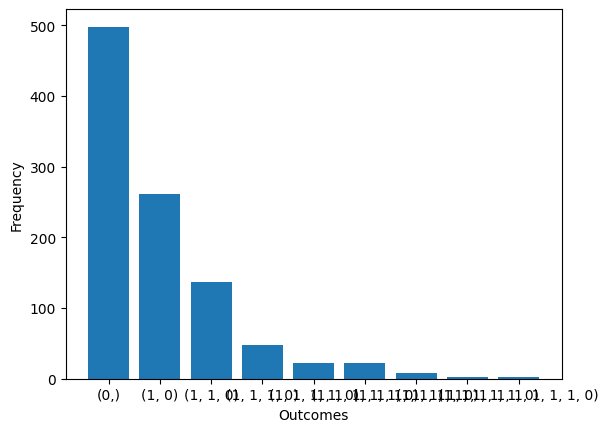

In [20]:
from qstack.machine import local_machine_for, create_callbacks

machine = local_machine_for(rep9_program.instruction_set, rep9_callbacks)
machine.eval(rep9_program, shots=1000).plot_histogram()


## Qiskit Implementation

Now let's implement the same functionality using Qiskit. We'll create:

1. A basic repeat-until-success circuit
2. A version with 3-qubit repetition code
3. A version with nested 9-qubit repetition code

Qiskit provides a different programming model where the classical control logic is written separately from the quantum circuit.

In [30]:
# Step 1: Basic repeat-until-success in Qiskit
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate, Parameter, Instruction
from qiskit.circuit.library import HGate
from qiskit.transpiler import PassManager, TransformationPass

# Define our custom "Mix" gate in Qiskit (equivalent to qstack's Mix gate)
class MixGate(Gate):
    def __init__(self):
        super().__init__('mix', 1, [])
        
    def _define(self):
        # In this toy implementation, Mix is just a Hadamard gate
        # But we'll treat it as a separate gate type that needs to be compiled
        pass

# Create a transpiler pass that replaces Mix gates with Hadamard gates
class MixToHadamardPass(TransformationPass):
    def run(self, dag):
        for node in dag.op_nodes():
            if node.name == 'mix':
                # Replace with Hadamard gate
                dag.substitute_node(node, HGate())
        return dag

# Define our basic circuit with the Mix gate
def create_basic_circuit_with_mix():
    circuit = QuantumCircuit(1, 1)
    # Add Mix gate instead of directly using H gate
    circuit.append(MixGate(), [0])
    circuit.measure(0, 0)
    return circuit

# Apply our transpiler pass to convert Mix to H
def compile_mix_to_h(circuit):
    pm = PassManager([MixToHadamardPass()])
    return pm.run(circuit)

# Execute with classical control flow for repeat-until-success
def run_repeat_until_success(max_attempts=100):
    simulator = AerSimulator()
    
    result = 1
    attempt = 0
    
    while result != 0 and attempt < max_attempts:
        # Create circuit with Mix gate
        circuit_with_mix = create_basic_circuit_with_mix()
        
        # Compile Mix to H
        compiled_circuit = compile_mix_to_h(circuit_with_mix)
        
        # Run the compiled circuit
        job_result = simulator.run(compiled_circuit, shots=1).result()
        counts = job_result.get_counts()
        result = int(list(counts.keys())[0])
        attempt += 1
        
    return attempt, "Success" if attempt < max_attempts else "Maximum attempts reached"

# Run the basic repeat-until-success circuit and display results
basic_attempts, status = run_repeat_until_success()
print(f"Repeat-until-success completed in {basic_attempts} attempts. Status: {status}")

# Display both the original circuit with Mix and the compiled circuit with H
basic_circuit_with_mix = create_basic_circuit_with_mix()
compiled_circuit = compile_mix_to_h(basic_circuit_with_mix)

print("Original circuit with Mix gate:")
print(basic_circuit_with_mix)
print("\nCompiled circuit with H gate:")
print(compiled_circuit)


Repeat-until-success completed in 3 attempts. Status: Success
Original circuit with Mix gate:
     ┌─────┐┌─┐
  q: ┤ Mix ├┤M├
     └─────┘└╥┘
c: 1/════════╩═
             0 

Compiled circuit with H gate:
     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 


### Step 1: Basic Implementation

In this first step, we've implemented a basic repeat-until-success pattern in Qiskit:

- We created a custom `MixGate` class to parallel qstack's toy instruction set
- We implemented a `MixToHadamardPass` transpiler pass that replaces Mix gates with Hadamard gates
- We use classical Python to control the retry logic
- Each attempt runs a separate circuit instance

This approach mimics qstack's instruction set translation. In Qiskit, this is done through the transpiler framework, which allows us to define custom passes that transform the circuit.

### Step 2: Transpiler and Error Correction

In the second step, we enhance our implementation by incorporating Qiskit's transpiler framework for error correction. This involves:

- Utilizing the transpiler to optimize the quantum circuit for the target backend
- Manually handling the decoding logic as per the requirements of our specific error correction code

The transpiler framework in Qiskit is a powerful tool that allows for low-level optimization and error correction of quantum circuits. By manually managing the decoding logic, we maintain control over the error correction process, tailoring it to the needs of our application.

In [31]:
# Step 2: Adding 3-Qubit Repetition Code
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Decompose

# Custom transpiler pass to expand a single qubit to repetition code
class RepetitionCodeTransformer:
    def __init__(self, distance=3):
        self.distance = distance
        
    def __call__(self, circuit):
        # Count how many qubits we're expanding from
        num_qubits = circuit.num_qubits
        num_clbits = circuit.num_clbits
        
        # Create new circuit with expanded qubits (distance qubits for each logical qubit)
        expanded_circuit = QuantumCircuit(
            num_qubits * self.distance, 
            num_qubits * self.distance  # Each physical qubit gets its own classical bit
        )
        
        # Map the original circuit's operations to the repetition code
        for instruction in circuit.data:
            gate = instruction.operation
            qargs = instruction.qubits
            
            # Map single-qubit gates to all physical qubits in the logical qubit's block
            if len(qargs) == 1 and gate.name != 'measure':
                logical_idx = circuit.find_bit(qargs[0]).index
                for i in range(self.distance):
                    physical_idx = logical_idx * self.distance + i
                    expanded_circuit.append(gate, [physical_idx], [])
            
            # Handle measurement operations specially
            elif gate.name == 'measure':
                logical_idx = circuit.find_bit(qargs[0]).index
                for i in range(self.distance):
                    physical_idx = logical_idx * self.distance + i
                    expanded_circuit.measure(physical_idx, physical_idx)
        
        return expanded_circuit

# Decoder function for repetition code - can be used at any level
def decode_repetition_code(measured_bits, logical_qubit_idx=0, distance=3):
    """
    Decode a repetition code for a specific logical qubit
    
    Parameters:
    - measured_bits: integer representing all measured bits
    - logical_qubit_idx: which logical qubit to decode (for multi-qubit circuits)
    - distance: distance of the repetition code (default=3)
    
    Returns:
    - decoded bit value (0 or 1)
    """
    # Convert to binary string and extract relevant bits
    if isinstance(measured_bits, int):
        # Convert integer to binary and extract relevant bits for this logical qubit
        start_pos = logical_qubit_idx * distance
        end_pos = start_pos + distance
        bit_string = format(measured_bits, f'0{end_pos}b')[-end_pos:(-start_pos if start_pos > 0 else None)]
    else:
        # If we already have a string
        bit_string = measured_bits
    
    # Count ones and apply majority vote
    ones_count = bit_string.count('1')
    return 1 if ones_count > distance // 2 else 0

# Create and apply our transformation
def create_error_corrected_circuit():
    # Start with circuit using Mix gate
    circuit_with_mix = create_basic_circuit_with_mix()
    
    # First apply the Mix to Hadamard compilation
    circuit_with_h = compile_mix_to_h(circuit_with_mix)
    
    # Then apply the repetition code transformation
    rep_code_transformer = RepetitionCodeTransformer(distance=3)
    return rep_code_transformer(circuit_with_h)

# Execution with error correction via majority voting
def run_error_corrected_repeat_until_success(max_attempts=100):
    simulator = AerSimulator()
    
    result = 1
    attempt = 0
    
    while result != 0 and attempt < max_attempts:
        circuit = create_error_corrected_circuit()
        job_result = simulator.run(circuit, shots=1).result()
        counts = job_result.get_counts()
        measured_bits = int(list(counts.keys())[0])
        
        # Using our decoder function for post-processing (manual integration)
        result = decode_repetition_code(measured_bits, logical_qubit_idx=0, distance=3)
        attempt += 1
        
    return attempt, "Success" if attempt < max_attempts else "Maximum attempts reached"

# Run the error-corrected repeat-until-success circuit and display results
ec_attempts, ec_status = run_error_corrected_repeat_until_success()
print(f"Error-corrected repeat-until-success completed in {ec_attempts} attempts. Status: {ec_status}")

# Display the circuit transformation steps
original_circuit = create_basic_circuit_with_mix()
compiled_circuit = compile_mix_to_h(original_circuit)
ec_circuit = create_error_corrected_circuit()

print(f"Original circuit with Mix gate:")
print(original_circuit)
print(f"\nCompiled circuit with H gate:")
print(compiled_circuit)
print(f"\nError-corrected circuit (3 qubits):")
print(f"Circuit expanded from 1 qubit to {ec_circuit.num_qubits} qubits")
print(ec_circuit)

Error-corrected repeat-until-success completed in 1 attempts. Status: Success
Original circuit with Mix gate:
     ┌─────┐┌─┐
  q: ┤ Mix ├┤M├
     └─────┘└╥┘
c: 1/════════╩═
             0 

Compiled circuit with H gate:
     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 

Error-corrected circuit (3 qubits):
Circuit expanded from 1 qubit to 3 qubits
     ┌───┐┌─┐      
q_0: ┤ H ├┤M├──────
     ├───┤└╥┘┌─┐   
q_1: ┤ H ├─╫─┤M├───
     ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─╫──╫─┤M├
     └───┘ ║  ║ └╥┘
c: 3/══════╩══╩══╩═
           0  1  2 


### Step 2: Adding Error Correction

In this step, we've added error correction using a 3-qubit repetition code:

- We keep our custom `MixGate` and transpiler pass from Step 1
- We first compile `Mix` to `H` gates using our transpiler pass
- Then we apply the repetition code transformation to the compiled circuit
- Each logical qubit becomes three physical qubits
- Operations are replicated across the physical qubits
- We implemented a `decode_repetition_code` function for majority voting

This mirrors qstack's approach of first translating the instruction set, then applying error correction. In Qiskit, we do this by chaining multiple transformations in sequence: first our custom transpiler pass, then the repetition code transformation.

In [33]:
# Step 3: Nested 9-Qubit Repetition Code
# Use composition of the same transpiler pass for nested codes
def create_nested_error_corrected_circuit():
    # Start with circuit using Mix gate
    circuit_with_mix = create_basic_circuit_with_mix()
    
    # First apply the Mix to Hadamard compilation
    circuit_with_h = compile_mix_to_h(circuit_with_mix)
    
    # First level of repetition code (3 qubits)
    level1_transformer = RepetitionCodeTransformer(distance=3)
    intermediate_circuit = level1_transformer(circuit_with_h)
    
    # Apply the same transformer again to create a nested code
    level2_transformer = RepetitionCodeTransformer(distance=3)
    nested_circuit = level2_transformer(intermediate_circuit)
    
    return nested_circuit

# Function to decode nested repetition code using the same base decoder
def decode_nested_repetition_code(measured_bits):
    """
    Decode a nested repetition code by applying the same decoder twice
    """
    # First level decoding - get 3 logical bits from 9 physical bits
    first_level_results = [
        decode_repetition_code(measured_bits, logical_qubit_idx=i, distance=3)
        for i in range(3)
    ]
    
    # Simply join the bits into a string for the second level decoding
    intermediate_result = ''.join(str(bit) for bit in first_level_results)
    
    # Apply the same decode_repetition_code function again for the second level
    return decode_repetition_code(intermediate_result, logical_qubit_idx=0, distance=3)

# Execution with nested error correction
def run_nested_error_corrected_repeat_until_success(max_attempts=100):
    simulator = AerSimulator()
    
    result = 1
    attempt = 0
    
    while result != 0 and attempt < max_attempts:
        circuit = create_nested_error_corrected_circuit()
        job_result = simulator.run(circuit, shots=1).result()
        counts = job_result.get_counts()
        measured_bits = int(list(counts.keys())[0])
        
        # Using our nested decoder function for post-processing
        result = decode_nested_repetition_code(measured_bits)
        attempt += 1
        
    return attempt, "Success" if attempt < max_attempts else "Maximum attempts reached"

# Run the nested error-corrected repeat-until-success circuit and display results
nested_attempts, nested_status = run_nested_error_corrected_repeat_until_success()
print(f"Nested error-corrected repeat-until-success completed in {nested_attempts} attempts. Status: {nested_status}")

# Display the circuit transformation steps
original_circuit = create_basic_circuit_with_mix()
compiled_circuit = compile_mix_to_h(original_circuit)
intermediate_circuit = RepetitionCodeTransformer(distance=3)(compiled_circuit)
nested_circuit = create_nested_error_corrected_circuit()

print(f"Original circuit with Mix gate:")
print(original_circuit)
print(f"\nCompiled circuit with H gate:")
print(compiled_circuit)
print(f"\nIntermediate circuit with 3-qubit repetition code:")
print(intermediate_circuit)
print(f"\nNested circuit with 9-qubit repetition code:")
print(nested_circuit)


Nested error-corrected repeat-until-success completed in 1 attempts. Status: Success
Original circuit with Mix gate:
     ┌─────┐┌─┐
  q: ┤ Mix ├┤M├
     └─────┘└╥┘
c: 1/════════╩═
             0 

Compiled circuit with H gate:
     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 

Intermediate circuit with 3-qubit repetition code:
     ┌───┐┌─┐      
q_0: ┤ H ├┤M├──────
     ├───┤└╥┘┌─┐   
q_1: ┤ H ├─╫─┤M├───
     ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─╫──╫─┤M├
     └───┘ ║  ║ └╥┘
c: 3/══════╩══╩══╩═
           0  1  2 

Nested circuit with 9-qubit repetition code:
     ┌───┐┌─┐                        
q_0: ┤ H ├┤M├────────────────────────
     ├───┤└╥┘┌─┐                     
q_1: ┤ H ├─╫─┤M├─────────────────────
     ├───┤ ║ └╥┘┌─┐                  
q_2: ┤ H ├─╫──╫─┤M├──────────────────
     ├───┤ ║  ║ └╥┘┌─┐               
q_3: ┤ H ├─╫──╫──╫─┤M├───────────────
     ├───┤ ║  ║  ║ └╥┘┌─┐            
q_4: ┤ H ├─╫──╫──╫──╫─┤M├────────────
     ├───┤ ║  ║  ║  ║ └╥┘┌─┐         
q_5: ┤

### Step 3: Nested Error Correction

In this final step, we've created a nested 9-qubit repetition code:

- We start with our `Mix` gate circuit
- We apply our transformations in sequence:
  1. First the `MixToHadamardPass` to convert `Mix` to `H` gates
  2. Then the first level of repetition code (3 qubits)
  3. Finally, the second level of repetition code (9 qubits)
- We wrote a `decode_nested_repetition_code` function that performs two-stage decoding
  - First applying decoding to each block of three physical qubits
  - Then applying decoding to the three logical results

This mirrors qstack's approach of first translating the instruction set, then applying repetition code compiler passes twice. In Qiskit, we explicitly chain the transpiler passes and transformations to achieve the same result.

## Comparing the Approaches

This notebook has demonstrated two different approaches to implementing a repeat-until-success pattern with error correction:

### qstack
- Uses a compiler-driven approach where transformations are applied to both quantum operations and classical callbacks
- Automatically handles resource expansion from 1 to 9 qubits
- Provides built-in support for callback composition and transformation
- Enables a unified programming model where quantum and classical code evolve together

### Qiskit
- Uses a modular approach with separate components for circuit transformation and result processing
- Offers flexibility in how classical control is structured
- Provides explicit control over circuit transformations through custom transpiler passes
- Maintains a clear separation between quantum circuit design and classical processing

### Key Parallels
- **Instruction set translation**: 
  - qstack: Mix → H through the toy2cliffords compiler
  - Qiskit: Mix → H through a custom transpiler pass
- **Error correction expansion**:
  - qstack: Automatic through the repetition compiler
  - Qiskit: Explicit through the RepetitionCodeTransformer
- **Nested error correction**:
  - qstack: Reapplying the same compiler pass
  - Qiskit: Explicit chaining of the same transformer
- **Decoder composition**:
  - qstack: Automatic through callback composition
  - Qiskit: Manual composition in decode_nested_repetition_code

### Packaging and Distribution

The components we developed for Qiskit could easily be packaged as external modules that encapsulate the implementation details:

```python
# Example of how Qiskit components might be organized in packages
from qiskit_custom_gates import MixGate
from qiskit_compiler_passes import MixToHadamardPass
from qiskit_error_correction import RepetitionCodeTransformer, decode_repetition_code
```

However, there's a key architectural difference in how callbacks are handled:

- **qstack**: Callbacks are automatically composed and invoked by the runtime system. When a program is executed, the machine automatically applies all necessary transformations and invokes the appropriate callbacks based on measurement results.

- **Qiskit**: While transpiler passes can be packaged and reused, callback invocation must be manually handled after each circuit execution. The user is responsible for:
  1. Running the circuit to get measurement results
  2. Manually invoking the appropriate decoder function
  3. Implementing the conditional logic for repeat-until-success patterns

This difference reflects the design philosophies of each framework:
- qstack focuses on high-level abstractions and automatic handling of the quantum-classical interface
- Qiskit provides fine-grained control and explicit handling of each transformation step

Both approaches can implement the same quantum algorithms, but with different programming models and different trade-offs in terms of automation versus explicit control.